In [1]:
# %pip install opencv-python-headless

In [2]:
def sprint(**kwargs):
    for name, val in kwargs.items():
        print(f"{name}: {val}")


In [3]:
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from PIL import Image, ImageDraw
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.transforms import functional as TF
from functools import lru_cache

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_BOXES = 1



In [4]:
def split_dataset(img_dir, label_dir, train_ratio=0.7, val_ratio=0.25, test_ratio=0.05, seed=42):
    random.seed(seed)

    IMG_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    LAB_EXT = '.txt'

    image_files = [f for f in sorted(os.listdir(img_dir)) if os.path.splitext(f)[1].lower() in IMG_EXTS]
    label_files = {f for f in os.listdir(label_dir) if f.lower().endswith(LAB_EXT)}

    pairs = []
    for img in image_files:
        base, _ = os.path.splitext(img)
        lbl = base + LAB_EXT
        if lbl in label_files:
            pairs.append((img, lbl))

    random.shuffle(pairs)
    total = len(pairs)
    n_train = int(total * train_ratio)
    n_val = int(total * val_ratio)

    train_pairs = pairs[:n_train]
    val_pairs = pairs[n_train:n_train + n_val]
    test_pairs = pairs[n_train + n_val:]

    return train_pairs, val_pairs, test_pairs


def collate_fixed_boxes(batch, max_boxes=MAX_BOXES):
    images, targets = zip(*batch)
    images = torch.stack(images, dim=0)

    batch_size = len(targets)

    l_padded = torch.zeros((batch_size, max_boxes, 4), dtype=torch.float32)
    s_padded = torch.zeros((batch_size, max_boxes, 4), dtype=torch.float32)
    for i, target in enumerate(targets):
        l_b = target["l_boxes"]
        l_n = l_b.size(0)
        l_padded[i, :l_n] = l_b[:max_boxes]

        s_b = target["s_boxes"]
        s_n = s_b.size(0)
        s_padded[i, :s_n] = s_b[:max_boxes]
    
    return images, {"l_boxes" : l_padded, "s_boxes" : s_padded}


def resize_image_and_boxes(image, boxes, size):
    """
    image: Tensor[C, H, W]
    boxes: Tensor[N, 4] in (x_min, y_min, x_max, y_max)
    size:   (new_h, new_w)
    """
    _, orig_h, orig_w = image.shape
    new_h, new_w = size

    # Resize image
    image = TF.resize(image, [new_h, new_w])

    # Compute scale factors
    scale_x = new_w / orig_w
    scale_y = new_h / orig_h

    # Adjust boxes
    boxes = boxes.clone()
    boxes[:, [0, 2]] = boxes[:, [0, 2]] * scale_x
    boxes[:, [1, 3]] = boxes[:, [1, 3]] * scale_y

    boxes[:, [4, 6]] = boxes[:, [4, 6]] * scale_x
    boxes[:, [5, 7]] = boxes[:, [5, 7]] * scale_y

    return image, boxes


class DualCompose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, boxes):
        for t in self.transforms:
            image, boxes = t(image, boxes)
        return image, boxes


class RandomFlip:
    def __init__(self, p_h=0.5, p_v=0.5):
        self.p_h = p_h
        self.p_v = p_v

    def __call__(self, tensor, boxes):
        _, h, w = tensor.shape
        flipped = False

        # Horizontal flip
        if random.random() < self.p_h:
            tensor = TF.hflip(tensor)
            boxes = boxes.clone()
            boxes[:, [0, 2]] = w - boxes[:, [2, 0]]  # flip x_min and x_max
            boxes[:, [4, 6]] = w - boxes[:, [6, 4]]  # flip x_min and x_max
            flipped = True
    
        # Vertical flip
        if random.random() < self.p_v:
            tensor = TF.vflip(tensor)
            boxes = boxes.clone()
            boxes[:, [1, 3]] = h - boxes[:, [3, 1]]  # flip y_min and y_max
            boxes[:, [5, 7]] = h - boxes[:, [7, 5]]  # flip y_min and y_max
            flipped = True
    
        return tensor, boxes


class AddGaussianNoise:
    def __init__(self, mean=0., std=0.01):
        self.mean = mean
        self.std = std

    def __call__(self, tensor, boxes):
        noise = torch.randn_like(tensor) * self.std + self.mean
        tensor = torch.clamp(tensor + noise, 0.0, 1.0)
        
        return tensor, boxes


class SyntheticDataset(Dataset):
    def __init__(self, file_pairs, img_dir, label_dir, transform=None, resize=None, test=False):
        self.image_files, self.label_files = zip(*file_pairs)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.resize = resize
        self.test = test

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        if not os.path.isfile(img_path):
            raise FileNotFoundError(f"Image file not found: {img_path}")
            
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if image is None:
            raise RuntimeError(f"OpenCV failed to load image: {img_path}")
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label_path = os.path.join(self.label_dir, self.label_files[idx])
        if not os.path.isfile(label_path):
            raise FileNotFoundError(f"Label file not found: {label_path}")
            
        boxes = []
        with open(label_path, 'r') as f:
            for line in f:
                box = list(map(int, line.strip().split()))
                boxes.append(box)
                
        boxes = torch.tensor(boxes, dtype=torch.float32)

        # Convert to PIL for augmentation if test mode is active
        if self.test:
            pil_image = Image.fromarray(image)
            pil_image = add_random_elements(pil_image, num_elements=3)
            image = np.array(pil_image)

        # Convert to tensor
        image = TF.to_tensor(image)
        image = TF.normalize(image, mean=[0.5]*3, std=[0.5]*3)

        if self.resize is not None:
            image, boxes = resize_image_and_boxes(image, boxes, self.resize)

        _, H, W = image.shape

        if self.transform is not None:
            image, boxes = self.transform(image, boxes)

        # normalize xyxy to [0,1]
        # boxes[:, [0,2]] /= H    # x_min, x_max
        # boxes[:, [1,3]] /= W    # y_min, y_max
        
        # now boxes[i] is in [0,1], return these as your GT
        target = {"s_boxes" : boxes[:,:4]}
        target.update({"l_boxes" : boxes[:,4:]})
        
        return image, target



In [5]:
def add_random_elements(image, num_elements=10):
    draw = ImageDraw.Draw(image)
    w, h = image.size

    for _ in range(num_elements):
        shape_type = random.choice(['circle', 'rectangle'])
        color = tuple(random.randint(0, 255) for _ in range(3))
        radius = random.randint(10, 20)

        if shape_type == 'circle':
            x = random.randint(radius, w - radius)
            y = random.randint(radius, h - radius)
            draw.ellipse((x - radius, y - radius, x + radius, y + radius), fill=color)

        elif shape_type == 'rectangle':
            x1 = random.randint(0, w - radius)
            y1 = random.randint(0, h - radius)
            x2 = x1 + random.randint(10, radius)
            y2 = y1 + random.randint(10, radius)
            draw.rectangle((x1, y1, x2, y2), fill=color)

    return image



In [6]:
IMAGE_DIR = 'images'
LABEL_DIR = 'labels'
HEATMAP_DIR = 'heatmaps_rgb'
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
NUM_IMAGES = 500
OUTPUT_DIR = 'data/hm_dataset_min_max'


train_data, valid_data, test_data = split_dataset(
    img_dir = os.path.join(OUTPUT_DIR,IMAGE_DIR),
    label_dir = os.path.join(OUTPUT_DIR,LABEL_DIR)
)

transform = DualCompose([
    RandomFlip(p_h=0.5, p_v=0.5),
    # AddGaussianNoise(mean=0., std=0.05)
])

train_dataset = SyntheticDataset(
    train_data, os.path.join(OUTPUT_DIR,IMAGE_DIR), os.path.join(OUTPUT_DIR,LABEL_DIR),
    transform = transform,
    resize = IMAGE_SIZE
)
valid_dataset = SyntheticDataset(
    valid_data, os.path.join(OUTPUT_DIR,IMAGE_DIR), os.path.join(OUTPUT_DIR,LABEL_DIR),
    transform = transform,
    resize = IMAGE_SIZE
)
test_dataset = SyntheticDataset(
    test_data, os.path.join(OUTPUT_DIR,IMAGE_DIR), os.path.join(OUTPUT_DIR,LABEL_DIR),
    transform = transform,
    resize = IMAGE_SIZE,
    test=True
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fixed_boxes)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fixed_boxes)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fixed_boxes)


In [7]:
print(f"Train/Val/Test sizes: {len(train_dataset)}/{len(valid_dataset)}/{len(test_dataset)}")
for imgs, hms in train_loader:
    print("batch imgs:", imgs.shape, "batch heatmaps:", len(hms))
    break


Train/Val/Test sizes: 3500/1250/250
batch imgs: torch.Size([32, 3, 256, 256]) batch heatmaps: 2


In [8]:
class GridAnchorDetector(nn.Module):
    def __init__(self, in_channels=64, num_anchors=3):
        super().__init__()
        self.box_head = nn.Conv2d(in_channels, num_anchors * 4, kernel_size=1)
        self.cls_head = nn.Conv2d(in_channels, num_anchors, kernel_size=1)

    def forward(self, feat):
        B, C, H, W = feat.shape
        offsets = self.box_head(feat).view(B, -1, 4)
        logits = self.cls_head(feat).view(B, -1)
        
        return offsets, logits


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size=3, padding=1, activation=nn.LeakyReLU, dropout=0.0):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            activation(),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        return self.block(x)


class AnchorGenerator():
    def __init__(self, stride=8, scales=[32, 64]):
        self.stride = stride
        self.scales = scales

    def generate(self, image_size):
        H = image_size[0] // self.stride
        W = image_size[1] // self.stride

        anchors = torch.empty((H * W * len(self.scales), 4), dtype=torch.float32)
        idx = 0
        for i in range(H):
            cy = (i + 0.5) * self.stride
            for j in range(W):
                cx = (j + 0.5) * self.stride
                
                for scale in self.scales:
                    anchors[idx, 0] = cx - scale / 2
                    anchors[idx, 1] = cy - scale / 2
                    anchors[idx, 2] = cx + scale / 2
                    anchors[idx, 3] = cy + scale / 2
                    idx += 1

        return anchors


class RoundObjectDetector(nn.Module):
    def __init__(self, image_size, iou_threshold=0.25):
        super().__init__()
        self.image_size = image_size
        self.iou_threshold = iou_threshold

        self.conv1 = ConvBlock(3,  16, dropout=0.05)
        self.conv2 = ConvBlock(16, 32, dropout=0.10)
        self.conv3 = ConvBlock(32, 64, dropout=0.20)
        self.pool = nn.MaxPool2d(2, 2)

        self.pool_factor = self._infer_stride(torch.zeros(1, 3, *image_size))
        ag = AnchorGenerator(stride=self.pool_factor, scales=[self.pool_factor]) # <-- insert more scales
        num_anchors = len(ag.scales)
        
        self.register_buffer("anchors", ag.generate(image_size))
        # num_anchors = self.anchors.size(0) // ((image_size[0] // self.stride) * (image_size[1] // self.stride))
        self.detector = GridAnchorDetector(in_channels=64, num_anchors=num_anchors)

    def _infer_stride(self, x):
        with torch.no_grad():
            x = self.conv1(x)
            x = self.pool(x)
            x = self.conv2(x)
            x = self.pool(x)
            x = self.conv3(x)
            feature_map_size = x.shape[2:]  # (H, W)

        stride_h = self.image_size[0] // feature_map_size[0]
        stride_w = self.image_size[1] // feature_map_size[1]

        assert stride_h == stride_w, "Non-square stride detected"
        return stride_h

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        
        offsets, logits = self.detector(x)
        # boxes = decode_offsets_to_boxes(offsets, self.anchors)
        
        return offsets, logits


def decode_offsets_to_boxes(offsets, anchors):
    anchors = anchors.to(offsets.device)
    print("offsets", offsets.shape)
    print("anchors", anchors.shape)

    anchor_centers = (anchors[..., :2] + anchors[..., 2:]) / 2
    anchor_sizes = anchors[..., 2:] - anchors[..., :2]

    pred_centers = offsets[..., :2] * anchor_sizes + anchor_centers
    pred_sizes = torch.exp(offsets[..., 2:]) * anchor_sizes

    boxes = torch.cat([
        pred_centers - pred_sizes / 2,
        pred_centers + pred_sizes / 2
    ], dim=-1)
    
    return boxes  # [B, N, 4]


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


def assign_targets_to_anchors(gt_boxes, anchors, iou_threshold=0.5):
    B, M, _ = gt_boxes.shape
    N = anchors.size(0)

    valid_mask = gt_boxes.abs().sum(dim=-1) > 0       # [B, M]
    gt_flat = gt_boxes.view(B * M, 4)               # [B*M, 4]
    ious_flat = compute_iou(gt_flat, anchors)         # [B*M, N]
    ious = ious_flat.view(B, M, N)               # [B, M, N]

    ious = ious.masked_fill(~valid_mask.unsqueeze(-1), float('-inf'))
    max_ious, max_idxs = ious.max(dim=1)              # both [B, N]

    object_mask = (max_ious > iou_threshold).float()  # [B, N]
    batch_idx = torch.arange(B, device=gt_boxes.device).unsqueeze(1).expand(-1, N)
    target_boxes = gt_boxes[batch_idx, max_idxs]       # [B, N, 4]
    
    return target_boxes, object_mask  # [B, N, 4], [B, N]


def compute_iou(boxes1, boxes2):
    # boxes1: [M, 4], boxes2: [N, 4]
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [M, N, 2]
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [M, N, 2]

    wh = (rb - lt).clamp(min=0)  # [M, N, 2]
    inter = wh[:, :, 0] * wh[:, :, 1]  # [M, N]

    union = area1[:, None] + area2 - inter
    min_area = torch.min(area1[:, None], area2[None, :])
    iou = inter / min_area  # [M, N]
    
    return iou


# def match_anchors_to_gt(gt_boxes, anchors, iou_threshold=0.5):
#     B, M, _ = gt_boxes.shape
#     N = anchors.size(0)
#     matched_mask = torch.zeros((B, N), dtype=torch.float32, device=gt_boxes.device)

#     for b in range(B):
#         valid_boxes = gt_boxes[b][gt_boxes[b].abs().sum(dim=-1) > 0]  # [M', 4]
#         if valid_boxes.numel() == 0:
#             continue
        
#         ious = compute_iou(valid_boxes, anchors)  # [M', N]
#         matched_mask[b] = (ious.max(dim=0).values > iou_threshold).float()
    
#     return matched_mask  # [B, N]


def focal_loss(logits, targets, alpha=0.25, gamma=2.0):
    prob = torch.sigmoid(logits)
    ce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    p_t = prob * targets + (1 - prob) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)
    alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
    
    return (loss * alpha_t).mean()


def encode_boxes_to_offsets(target_boxes, anchors):
    # target_boxes: [B, N, 4], anchors: [N, 4]
    anchor_centers = (anchors[:, :2] + anchors[:, 2:]) / 2  # [N,2]
    anchor_sizes =  anchors[:, 2:] - anchors[:, :2]      # [N,2]

    # expand to batch size
    B = target_boxes.size(0)
    anchor_centers = anchor_centers.unsqueeze(0).expand(B, -1, -1)
    anchor_sizes = anchor_sizes.unsqueeze(0).expand(B, -1, -1)

    target_centers = (target_boxes[..., :2] + target_boxes[..., 2:]) / 2
    target_sizes = target_boxes[..., 2:] - target_boxes[..., :2]
    
    offsets = torch.zeros_like(target_boxes)
    offsets[..., :2] = (target_centers - anchor_centers) / anchor_sizes
    offsets[..., 2:] = torch.log((target_sizes + 1e-8) / anchor_sizes)

    return offsets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


anchors torch.Size([4096, 4])
l_gt_boxes torch.Size([1, 4])
valid_boxes.shape torch.Size([1, 4])
anchors.shape torch.Size([4096, 4])
torch.Size([1, 4096, 4])
tensor([[[ 94.4000,  56.8000, 206.0000, 171.6000],
         [ 94.4000,  56.8000, 206.0000, 171.6000],
         [ 94.4000,  56.8000, 206.0000, 171.6000],
         ...,
         [ 94.4000,  56.8000, 206.0000, 171.6000],
         [ 94.4000,  56.8000, 206.0000, 171.6000],
         [ 94.4000,  56.8000, 206.0000, 171.6000]]])


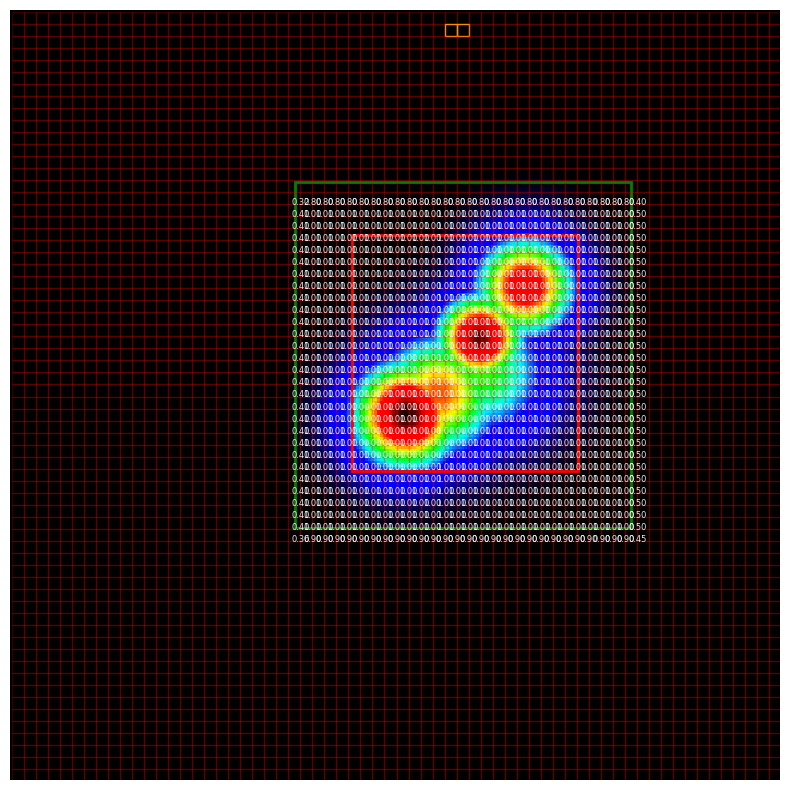

In [10]:
import torch
import matplotlib.pyplot as plt
from matplotlib import patches
from PIL import Image

def tmp_assign_targets_to_anchors(gt_boxes, anchors, iou_threshold=0.5):
    B, M = gt_boxes.shape
    N = anchors.size(0)
    target_boxes = torch.zeros((B, N, 4), dtype=torch.float32, device=gt_boxes.device)
    object_mask = torch.zeros((B, N), dtype=torch.float32, device=gt_boxes.device)

    for b in range(B):
        valid_boxes = gt_boxes[b][gt_boxes[b].abs().sum(dim=-1) > 0]  # [M', 4]
        if valid_boxes.numel() == 0:
            continue

        print("valid_boxes.shape", valid_boxes.shape)
        print("anchors.shape", anchors.shape)
        ious = compute_iou(valid_boxes, anchors)  # [M', N]
        max_ious, max_idxs = ious.max(dim=0)  # [N]
        object_mask[b] = (max_ious > iou_threshold).float()
        target_boxes[b] = valid_boxes[max_idxs]  # assign best-matching box to each anchor
        
    return target_boxes, object_mask  # [B, N, 4], [B, N]


# Load and resize
img, label = train_dataset.__getitem__(2)
img = img.permute(1,2,0).numpy()

# Generate anchors
stride_factor = IMAGE_SIZE[0]//pow(2,5)
pool_factor = 4
ag = AnchorGenerator(stride=pool_factor, scales=[pool_factor])
anchors = ag.generate(IMAGE_SIZE)
print("anchors", anchors.shape)

# Set up plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img)
ax.axis("off")


def tmp_draw_box(box, edgecolor):
    x1, y1, x2, y2 = box
    w,h = x2 - x1, y2 - y1
    rect = Rectangle((x1, y1), w, h, linewidth=2, edgecolor=edgecolor, facecolor='none')
    ax.add_patch(rect)


# draw GT in red
l_gt_boxes = label['l_boxes']
print("l_gt_boxes", l_gt_boxes.shape)
target_boxes, object_mask = tmp_assign_targets_to_anchors(l_gt_boxes, anchors, iou_threshold=0.25)
print(target_boxes.shape)
print(target_boxes)
object_mask = object_mask[0, :]

if l_gt_boxes is not None:
    for box in l_gt_boxes.tolist():
        tmp_draw_box(box, edgecolor='g')

    ious = compute_iou(anchors, l_gt_boxes)
    # For each anchor, take the highest IoU against any l_box
    max_ious, _ = ious.max(dim=1)  # Tensor [num_anchors]

else:
    # fallback to zeros if no GT
    max_ious = torch.zeros(anchors.size(0))


s_gt_boxes = label['s_boxes']
if s_gt_boxes is not None:
    for box in s_gt_boxes.tolist():
        tmp_draw_box(box, edgecolor='r')


# Choose a colormap for different scales
colors = ["red", "violet", "darkorange", "green"]
scale_idx = (anchors[:,2] - anchors[:,0]).int()
scale_uid = torch.unique(scale_idx).sort().values
scale_idx = (scale_idx.unsqueeze(-1) == scale_uid).long()
scale_idx = scale_idx.argmax(dim=-1)

# Draw each anchor
for idx, (color, box, mask) in enumerate(zip(scale_idx, anchors, object_mask)):
    xmin, ymin, xmax, ymax = box.tolist()

    # Determine color by scale index
    if idx == 100:
        color += 2
        alpha = 1.0
        
    elif idx == 101:
        color += 2
        alpha = 1.0
        
    else:
        alpha = 0.2
    
    rect = patches.Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        linewidth=1,
        edgecolor=colors[color],
        facecolor="none",
        alpha=alpha
    )
    ax.add_patch(rect)

    # overlay IoU text (two decimal places)
    if mask == 1:
        iou_val = max_ious[idx].item()
        ax.text(xmin + 1, ymin + 6, f"{iou_val:.2f}", fontsize=6, color='white', alpha=0.9, verticalalignment="top")

plt.tight_layout()
plt.show()


In [23]:
def train_one_epoch(model, dataloader, optimizer, epoch, warmup_epochs, lambda_cls, lambda_reg, max_grad_norm):
    model.train()
    running_loss = 0.0
    anchors = model.anchors.to(DEVICE)
    
    use_focal = epoch > warmup_epochs
    for images, gt_boxes in dataloader:
        images = images.to(DEVICE)           # [B, 3, H, W]
        gt_boxes = gt_boxes['l_boxes'].to(DEVICE)         # [B, M, 4] padded with zeros

        # forward
        pred_offsets, pred_logits = model(images)   # [B, N, 4], [B, N]

        # assign anchors → targets
        target_boxes, object_mask = assign_targets_to_anchors(gt_boxes, anchors, iou_threshold=model.iou_threshold)

        # encode boxes
        target_offsets = encode_boxes_to_offsets(target_boxes, anchors)

        # print("pred_offsets", pred_offsets.shape)
        # print("pred_logits", pred_logits.shape)
        # print("target_boxes", target_boxes.shape)
        # print("object_mask", object_mask.shape)
        # print("target_offsets", target_offsets.shape)

        # classification loss
        if use_focal:
            cls_loss = focal_loss(pred_logits, object_mask)
            
        else:
            cls_loss = F.binary_cross_entropy_with_logits(pred_logits, object_mask)

        # regression loss (only positives)
        pos_mask = object_mask.bool()           # [B, N]
        if pos_mask.any():
            reg_loss = F.smooth_l1_loss(pred_offsets[pos_mask], target_offsets[pos_mask], reduction='mean')
            
        else:
            reg_loss = torch.tensor(0.0, device=DEVICE)

        # total loss
        loss = lambda_cls * cls_loss + lambda_reg * reg_loss

        # backward & optimize
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    
    return epoch_loss


def validate_one_epoch(model, dataloader, lambda_cls, lambda_reg):
    model.eval()
    running_loss = 0.0
    anchors = model.anchors.to(DEVICE)

    with torch.no_grad():
        for images, gt_boxes in dataloader:
            images = images.to(DEVICE)
            gt_boxes = gt_boxes['l_boxes'].to(DEVICE)

            pred_offsets, pred_logits = model(images)
            target_boxes, object_mask = assign_targets_to_anchors(gt_boxes, anchors, iou_threshold=model.iou_threshold)
            target_offsets = encode_boxes_to_offsets(target_boxes, anchors)

            cls_loss = F.binary_cross_entropy_with_logits(pred_logits, object_mask)
            pos_mask = object_mask.bool()
            if pos_mask.any():
                reg_loss = F.smooth_l1_loss(pred_offsets[pos_mask], target_offsets[pos_mask], reduction='mean')
                
            else:
                reg_loss = torch.tensor(0.0, device=DEVICE)

            loss = lambda_cls * cls_loss + lambda_reg * reg_loss
            running_loss += loss.item() * images.size(0)

    return running_loss / len(dataloader.dataset)



In [24]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Hyperparameters ---
NUM_EPOCHS = 30
BATCH_SIZE = 32
LR = 0.02
warmup_epochs = 5
lambda_cls = 0.01
lambda_reg = 1.0
max_grad_norm = 1.0
patience = 10

# --- Model, Optimizer ---
model = RoundObjectDetector(image_size=IMAGE_SIZE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [25]:
# --- Early Stopping Setup ---
best_val_loss = float("inf")
epochs_no_improve = 0

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, epoch, warmup_epochs, lambda_cls, lambda_reg, max_grad_norm)
    val_loss = validate_one_epoch(model, valid_loader, lambda_cls, lambda_reg)

    print(f"Epoch {epoch:02d} — Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "saved_models/best_detector.pth")
        epochs_no_improve = 0
        
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"No improvement for {patience} epochs. Early stopping.")
            break


Epoch 01 — Train Loss: 3.5285  Val Loss: 3.4318
Epoch 02 — Train Loss: 3.4735  Val Loss: 3.4358
Epoch 03 — Train Loss: 3.4691  Val Loss: 3.4591
Epoch 04 — Train Loss: 3.4672  Val Loss: 3.4426
Epoch 05 — Train Loss: 3.4656  Val Loss: 3.4357
Epoch 06 — Train Loss: 3.4624  Val Loss: 3.4605
Epoch 07 — Train Loss: 3.4623  Val Loss: 3.4516
Epoch 08 — Train Loss: 3.4599  Val Loss: 3.4267
Epoch 09 — Train Loss: 3.4580  Val Loss: 3.4444
Epoch 10 — Train Loss: 3.4597  Val Loss: 3.4520
Epoch 11 — Train Loss: 3.4579  Val Loss: 3.4481
Epoch 12 — Train Loss: 3.4574  Val Loss: 3.4274
Epoch 13 — Train Loss: 3.4553  Val Loss: 3.4427
Epoch 14 — Train Loss: 3.4543  Val Loss: 3.4585
Epoch 15 — Train Loss: 3.4540  Val Loss: 3.4756
Epoch 16 — Train Loss: 3.4568  Val Loss: 3.4472
Epoch 17 — Train Loss: 3.4547  Val Loss: 3.4546
Epoch 18 — Train Loss: 3.4558  Val Loss: 3.4285
No improvement for 10 epochs. Early stopping.


In [26]:
model = RoundObjectDetector(image_size=IMAGE_SIZE).to(DEVICE)

PATH = "saved_models/best_detector.pth"
model.load_state_dict(torch.load(PATH, map_location=DEVICE))

model.eval() is not None

True

[0.22573012 0.14144701 0.0180138  ... 0.28673846 0.11122909 0.10743741]


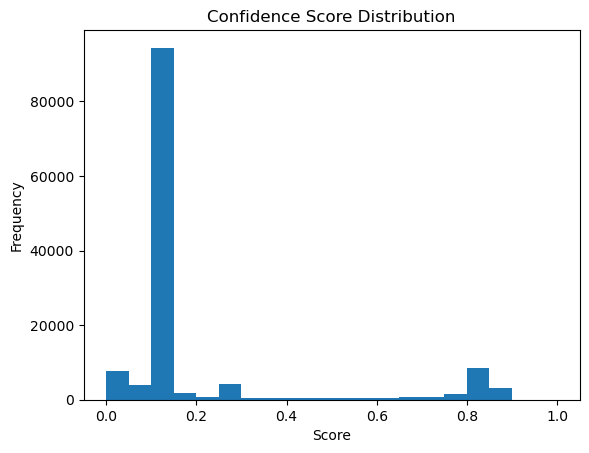

In [27]:
import matplotlib.pyplot as plt

conf_logits_list = []
model.eval()
with torch.no_grad():
    images, _ = next(iter(valid_loader))
    images = images.to(DEVICE)
    _, conf_logits = model(images)
    conf_logits_list.append(conf_logits)
    conf_scores = torch.sigmoid(conf_logits)

conf_scores = conf_scores.cpu().flatten().numpy()
print(conf_scores)
plt.hist(conf_scores, bins=20, range=(0, 1))
plt.title("Confidence Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


offsets torch.Size([32, 4096, 4])
anchors torch.Size([4096, 4])
1.0
Image shape: torch.Size([3, 256, 256])
 GT boxes: torch.Size([1, 4])
Pred boxes+conf: 4096 x 5

torch.Size([4096, 4])
[(0.8995543718338013, tensor([ 52.0557, 111.1111, 127.2393, 188.2536])), (0.8926730751991272, tensor([ 48.9051, 112.9150, 122.3814, 186.3714])), (0.8706458806991577, tensor([ 50.6534,  45.8855, 164.0065, 160.8490])), (0.8702353835105896, tensor([ 59.9236,  56.4529, 162.5723, 157.9078])), (0.8702018857002258, tensor([ 54.7689,  47.5510, 168.0099, 159.1606])), (0.8687828779220581, tensor([ 51.8352,  51.4070, 162.8349, 163.2229])), (0.8687408566474915, tensor([ 50.2885,  43.2875, 164.3359, 155.3244])), (0.8686813116073608, tensor([ 43.6062, -16.3938, 189.1471, 129.1471])), (0.8685848116874695, tensor([ 63.7101,  58.3191, 166.1797, 155.6443])), (0.8685271739959717, tensor([ 59.9761,  60.2115, 161.8306, 161.6307]))]


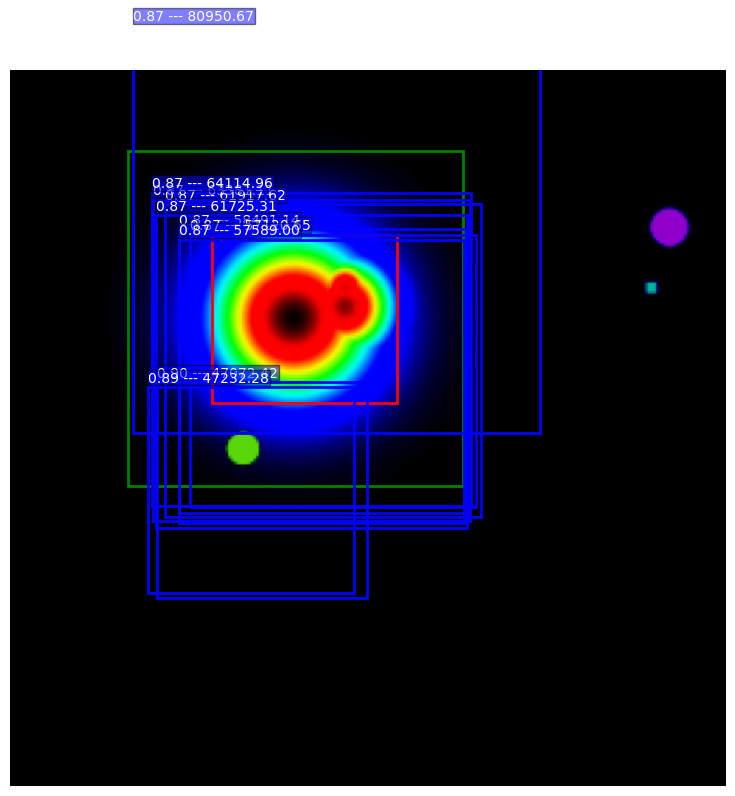

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


1.0
Image shape: torch.Size([3, 256, 256])
 GT boxes: torch.Size([1, 4])
Pred boxes+conf: 4096 x 5

torch.Size([4096, 4])
[(0.8739840388298035, tensor([124.8997, 120.8997, 198.3868, 194.3868])), (0.8735240697860718, tensor([128.8998, 124.9007, 202.3867, 198.3859])), (0.8730465173721313, tensor([127.1112, 126.1588, 204.2699, 205.3592])), (0.8723446130752563, tensor([124.8997, 124.8997, 198.3868, 198.3868])), (0.8719093799591064, tensor([116.8997, 116.8997, 190.3868, 190.3868])), (0.8716369867324829, tensor([128.0789, 131.7533, 203.2759, 207.5753])), (0.8714760541915894, tensor([112.8997, 116.8997, 186.3868, 190.3868])), (0.8712161779403687, tensor([120.8997, 120.8997, 194.3868, 194.3868])), (0.8710387349128723, tensor([120.8997, 116.8997, 194.3868, 190.3868])), (0.8706514835357666, tensor([124.9270, 128.8217, 198.3575, 202.4603]))]


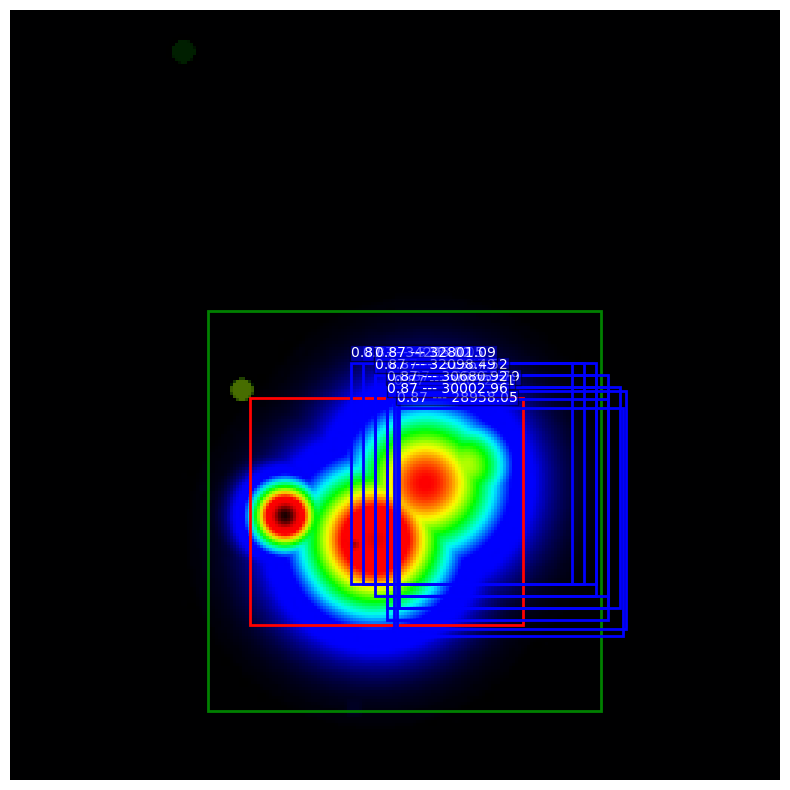

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


1.0
Image shape: torch.Size([3, 256, 256])
 GT boxes: torch.Size([1, 4])
Pred boxes+conf: 4096 x 5

torch.Size([4096, 4])
[(0.87416011095047, tensor([157.0817,  85.0817, 239.0817, 167.0817])), (0.8724931478500366, tensor([157.0817,  81.0817, 239.0817, 163.0817])), (0.8720185160636902, tensor([157.0817,  89.0817, 239.0817, 171.0817])), (0.8718532919883728, tensor([154.5909,  80.2168, 249.5725, 179.9466])), (0.8713908791542053, tensor([153.0817,  81.0817, 235.0817, 163.0817])), (0.871341347694397, tensor([153.0817,  85.0817, 235.0817, 167.0817])), (0.8706172704696655, tensor([189.0817,  77.0817, 271.0817, 159.0817])), (0.8703150153160095, tensor([185.0817,  69.0817, 267.0817, 151.0817])), (0.8701081871986389, tensor([189.0817,  73.0817, 271.0817, 155.0817])), (0.869566023349762, tensor([181.0817,  65.0817, 263.0817, 147.0817]))]


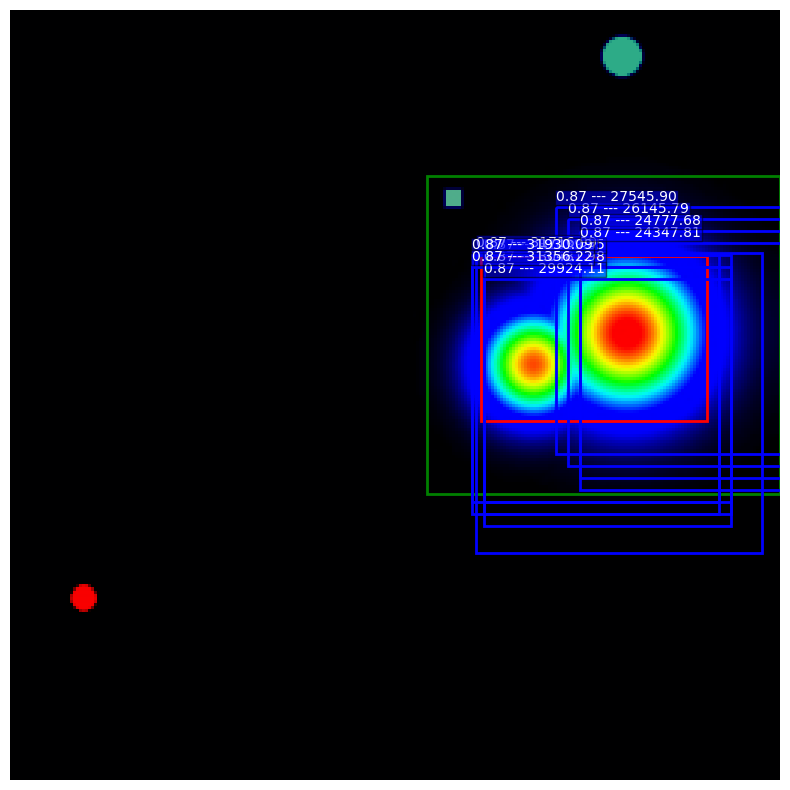

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


1.0
Image shape: torch.Size([3, 256, 256])
 GT boxes: torch.Size([1, 4])
Pred boxes+conf: 4096 x 5

torch.Size([4096, 4])
[(0.870162844657898, tensor([ 22.9661, 116.3793, 124.3204, 222.9072])), (0.8692081570625305, tensor([ 22.9661, 120.3793, 124.3204, 226.9072])), (0.8685943484306335, tensor([ 31.1161, 113.0150, 104.6032, 186.5020])), (0.8675063848495483, tensor([ 27.5670,  96.4722, 109.5670, 178.4721])), (0.8669414520263672, tensor([ 31.1161, 117.0191, 104.6031, 190.4979])), (0.8668916821479797, tensor([ 41.0817,  97.0817, 123.0817, 179.0817])), (0.8666682243347168, tensor([ 26.5909,  88.2168, 121.5725, 187.9466])), (0.866599977016449, tensor([ 22.9661, 124.3793, 124.3204, 230.9072])), (0.8665186762809753, tensor([ 22.9661, 112.3793, 124.3204, 218.9072])), (0.8664957880973816, tensor([ 32.8997, 136.8997, 106.3868, 210.3868]))]


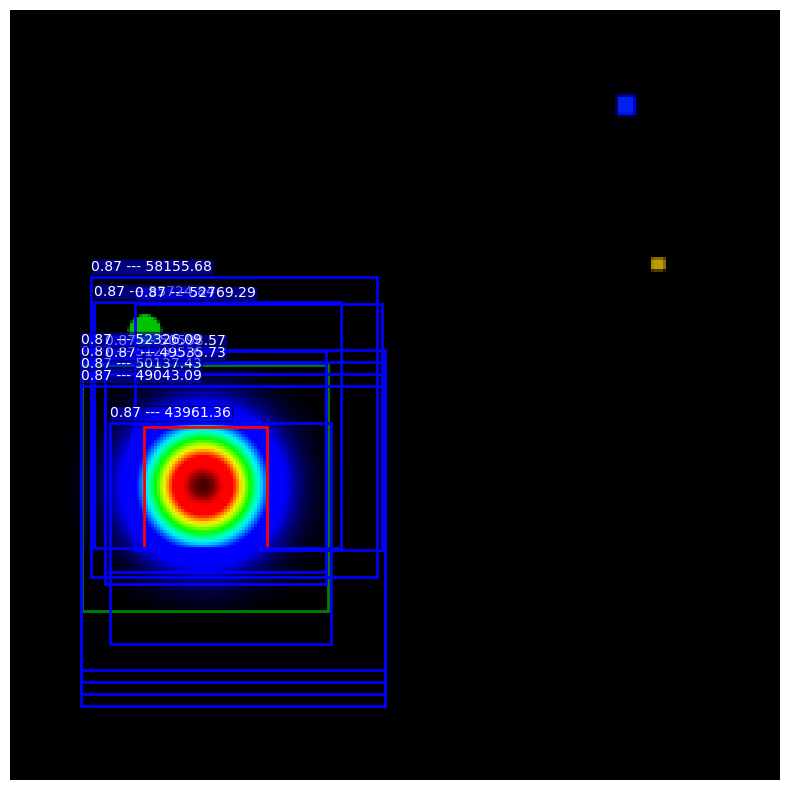

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


1.0
Image shape: torch.Size([3, 256, 256])
 GT boxes: torch.Size([1, 4])
Pred boxes+conf: 4096 x 5

torch.Size([4096, 4])
[(0.8862438201904297, tensor([139.0324,  66.4877, 208.9947, 137.1569])), (0.8821594715118408, tensor([129.0817,  57.0906, 211.0817, 139.0728])), (0.8798519372940063, tensor([129.0817,  61.0930, 211.0817, 143.0704])), (0.8715693354606628, tensor([133.9172,  55.1655, 214.3078, 141.2768])), (0.8634808659553528, tensor([150.6512,  69.3428, 197.5122, 118.6051])), (0.8598959445953369, tensor([129.0817,  53.0817, 211.0817, 135.0817])), (0.8556123375892639, tensor([125.0817,  57.0817, 207.0817, 139.0817])), (0.853379487991333, tensor([125.0817,  61.0817, 207.0817, 143.0817])), (0.8473351001739502, tensor([111.0645,  23.0645, 214.9949, 126.9949])), (0.8427332639694214, tensor([125.0817,  65.0817, 207.0817, 147.0817]))]


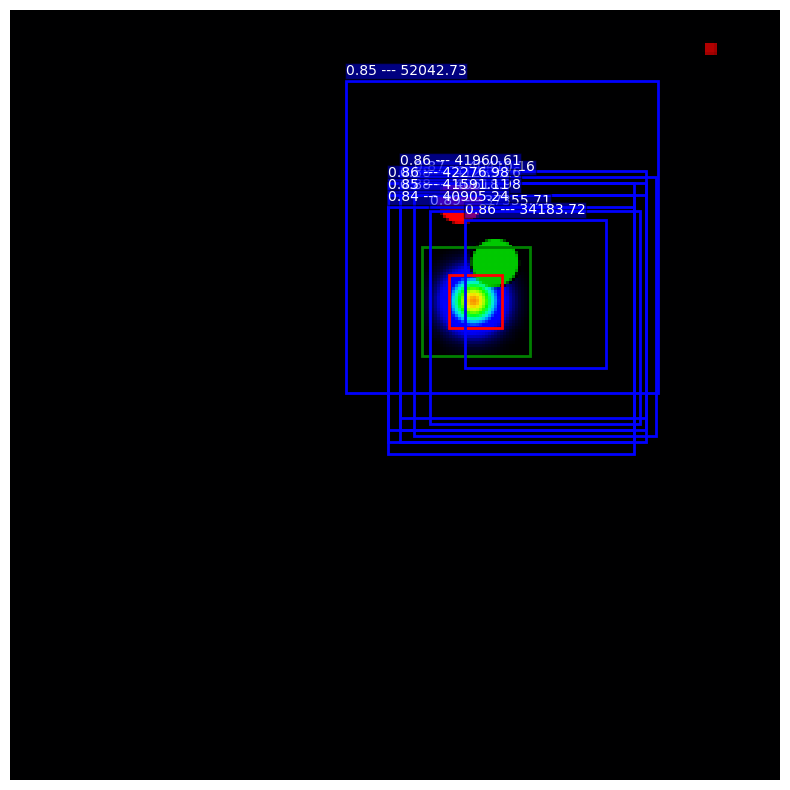

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


1.0
Image shape: torch.Size([3, 256, 256])
 GT boxes: torch.Size([1, 4])
Pred boxes+conf: 4096 x 5

torch.Size([4096, 4])
[(0.8758367896080017, tensor([ 46.2416,  30.4129, 160.7371, 144.4912])), (0.8756741285324097, tensor([ 44.5097,  34.9449, 162.7056, 148.2956])), (0.8755041360855103, tensor([ 44.1436,  43.7050, 154.5832, 154.8675])), (0.8751248121261597, tensor([ 45.1735,  36.9671, 161.7127, 153.9358])), (0.8750909566879272, tensor([ 37.1645,  37.2106, 153.7794, 153.6148])), (0.8749350905418396, tensor([ 39.1484,  42.9705, 151.7205, 155.7191])), (0.8745875358581543, tensor([ 40.1524,  28.6923, 158.9261, 146.4325])), (0.8744586110115051, tensor([ 52.0273,  36.8829, 162.5695, 145.6945])), (0.8741098642349243, tensor([ 45.7340,  42.3566, 160.9398, 156.4902])), (0.8740746378898621, tensor([ 34.5138,  31.4131, 156.3554, 151.8055]))]


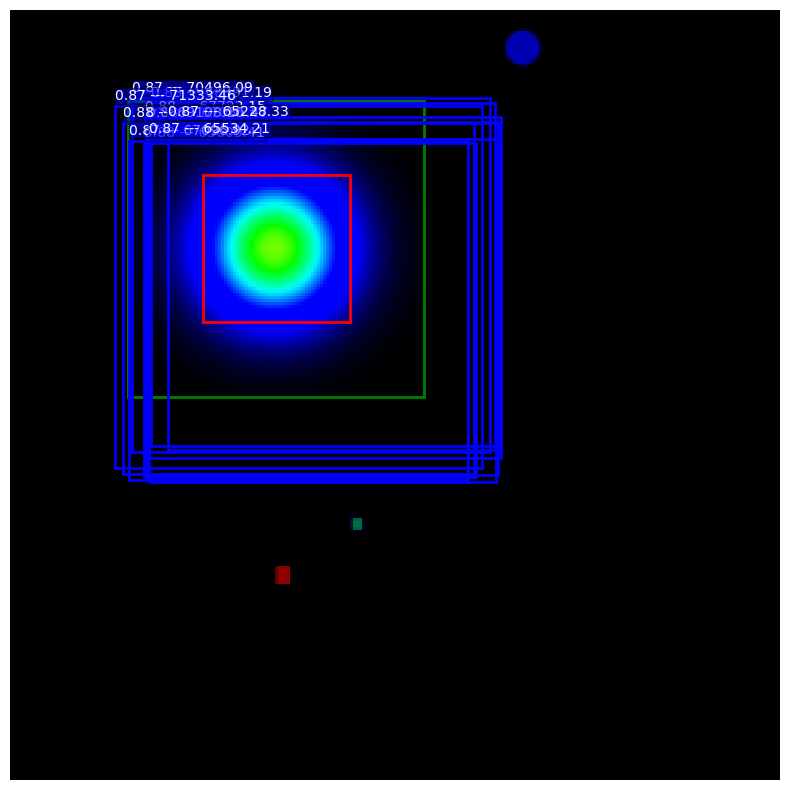

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


1.0
Image shape: torch.Size([3, 256, 256])
 GT boxes: torch.Size([1, 4])
Pred boxes+conf: 4096 x 5

torch.Size([4096, 4])
[(0.8733561038970947, tensor([144.8997, 124.8997, 218.3868, 198.3868])), (0.8717483878135681, tensor([153.2664, 138.1935, 210.5308, 193.2577])), (0.8690431714057922, tensor([140.8997, 124.8997, 214.3868, 198.3868])), (0.8683704733848572, tensor([136.7657, 128.5748, 210.5195, 202.7161])), (0.8681477904319763, tensor([140.8997, 120.8997, 214.3868, 194.3868])), (0.8680409789085388, tensor([138.9096, 126.6501, 216.5476, 204.9338])), (0.8678699731826782, tensor([133.0817,  93.0817, 215.0817, 175.0817])), (0.8674898743629456, tensor([144.8997, 120.8997, 218.3868, 194.3868])), (0.8672124743461609, tensor([132.8997, 128.9027, 206.3868, 202.3839])), (0.8672035932540894, tensor([137.0817,  93.0817, 219.0817, 175.0817]))]


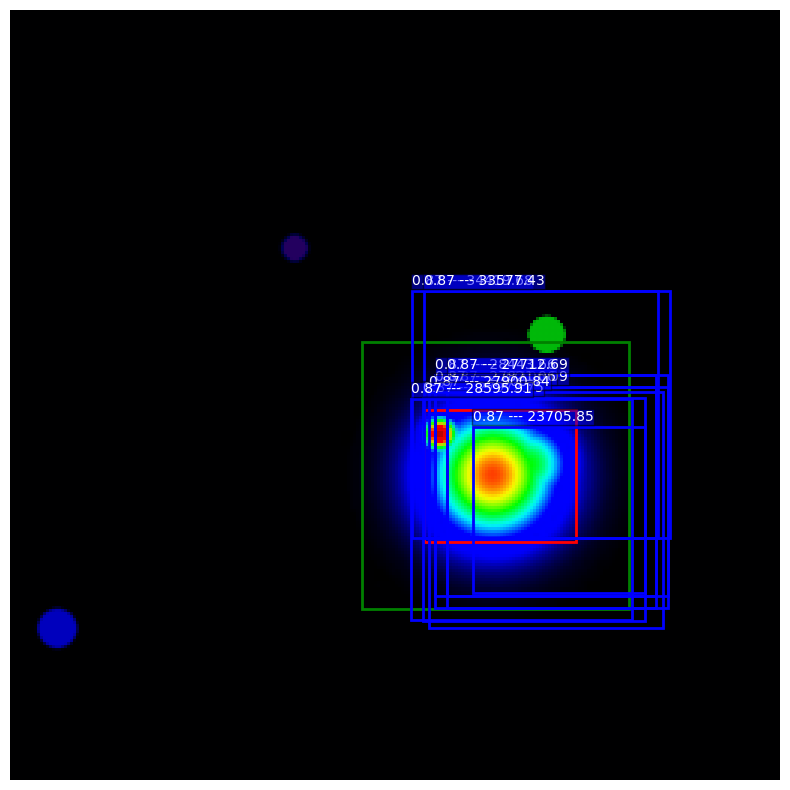

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


1.0
Image shape: torch.Size([3, 256, 256])
 GT boxes: torch.Size([1, 4])
Pred boxes+conf: 4096 x 5

torch.Size([4096, 4])
[(0.8698890209197998, tensor([113.0817,  65.0817, 195.0817, 147.0817])), (0.8684459924697876, tensor([113.0817,  61.0817, 195.0817, 143.0817])), (0.8672017455101013, tensor([116.0242,  60.1125, 200.1392, 144.0501])), (0.8663619160652161, tensor([109.0817,  65.0817, 191.0817, 147.0817])), (0.8661689162254333, tensor([117.6941,  67.1692, 198.4692, 144.9503])), (0.8660946488380432, tensor([113.0817,  69.0817, 195.0817, 151.0817])), (0.8644117712974548, tensor([109.0817,  61.0817, 191.0817, 143.0817])), (0.8631653189659119, tensor([117.0638,  57.0184, 199.0996, 139.1451])), (0.8626728057861328, tensor([113.7873,  51.7355, 210.5481, 153.2278])), (0.8624805212020874, tensor([-16.3938,  -8.3938, 129.1471, 137.1471]))]


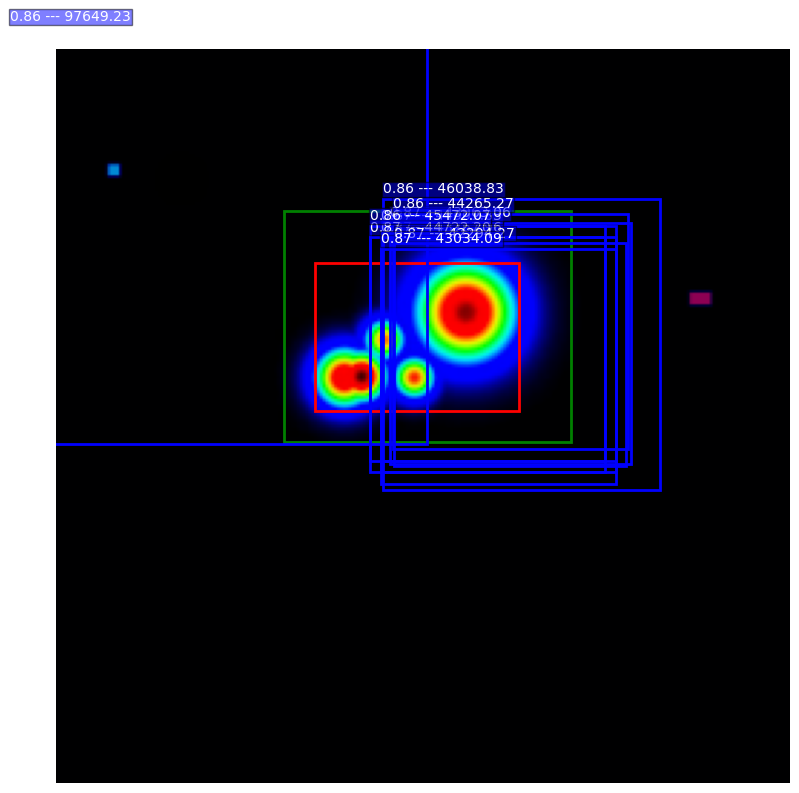

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


1.0
Image shape: torch.Size([3, 256, 256])
 GT boxes: torch.Size([1, 4])
Pred boxes+conf: 4096 x 5

torch.Size([4096, 4])
[(0.8720163702964783, tensor([ 65.7838, 165.4040, 137.0692, 237.5411])), (0.8713327646255493, tensor([ 62.9722, 166.8602, 131.8390, 235.9125])), (0.8696157932281494, tensor([ 74.1244, 178.1244, 126.4442, 230.4442])), (0.8691431283950806, tensor([ 70.1244, 178.1244, 122.4442, 230.4442])), (0.8691069483757019, tensor([ 65.7702, 165.6366, 128.1810, 228.3167])), (0.8688896298408508, tensor([ 69.5653, 165.3668, 132.4871, 228.7116])), (0.8674691319465637, tensor([ 68.8666, 164.8909, 142.3499, 238.3779])), (0.8674030303955078, tensor([ 71.6991, 179.6991, 129.6933, 237.6933])), (0.8673612475395203, tensor([ 58.1939, 166.5954, 129.0100, 236.5123])), (0.8669608235359192, tensor([ 67.6991, 179.6991, 125.6933, 237.6933]))]


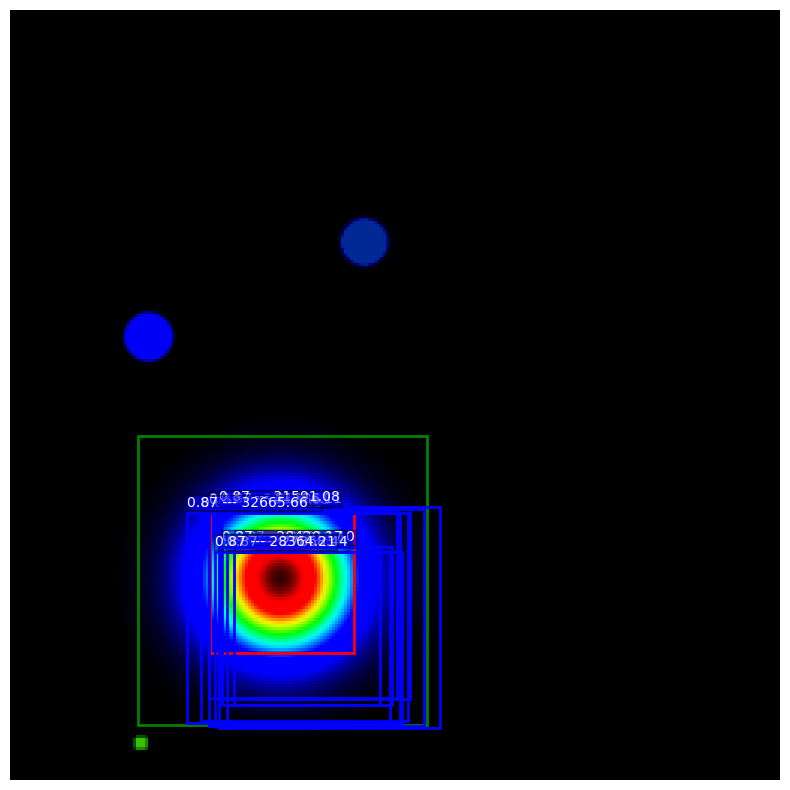

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


1.0
Image shape: torch.Size([3, 256, 256])
 GT boxes: torch.Size([1, 4])
Pred boxes+conf: 4096 x 5

torch.Size([4096, 4])
[(0.8766387701034546, tensor([143.1367, 135.4901, 220.5358, 212.1931])), (0.8765567541122437, tensor([142.4219, 130.6647, 221.4740, 209.2262])), (0.8754499554634094, tensor([143.4347, 139.2153, 220.0993, 216.3191])), (0.8747501373291016, tensor([140.9094, 124.9177, 214.5222, 198.4372])), (0.8745959997177124, tensor([141.8457, 125.4890, 222.0721, 206.4424])), (0.8737910389900208, tensor([140.2099, 155.8776, 205.8239, 222.3295])), (0.8730202317237854, tensor([132.8997, 120.8997, 206.3868, 194.3868])), (0.8730165958404541, tensor([138.9989, 126.0536, 216.5261, 205.5175])), (0.872844934463501, tensor([143.9426, 143.9181, 219.5491, 219.5312])), (0.8728229403495789, tensor([135.5714, 123.9935, 212.2762, 199.7564]))]


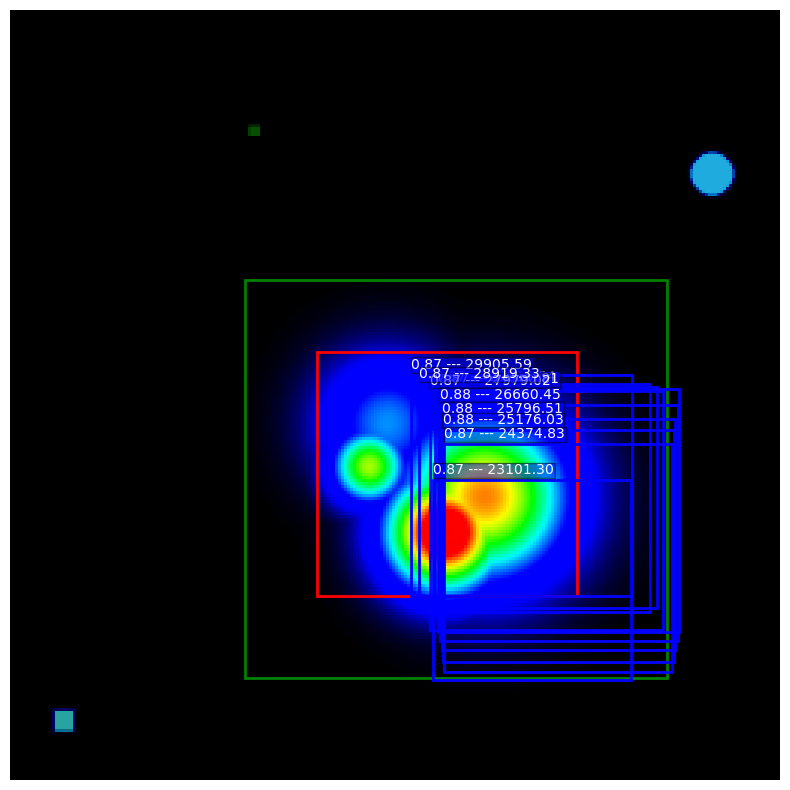

In [66]:
def show_boxes_with_confidence(image_tensor, l_gt_boxes=None, s_gt_boxes=None, pred_boxes=None, confidences=None, figsize=(8,8), box_kwargs=None, text_kwargs=None):
    """
    Draw GT (red) and predicted (blue) boxes.  
    If confidences is provided, writes 'c=0.83' at top-left of each pred box.
    """

    num_boxes = 10
    
    # defaults
    box_kwargs = box_kwargs or {}
    text_kwargs = text_kwargs or dict(color='white', fontsize=10, bbox=dict(facecolor='blue', alpha=0.5, pad=0.5))

    # prep image
    img = image_tensor.permute(1,2,0).numpy()

    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')

    ax = plt.gca()

    def _draw_box(box, edgecolor):
        x1, y1, x2, y2 = box
        w,h = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), w, h, linewidth=2, edgecolor=edgecolor, facecolor='none', **box_kwargs)
        ax.add_patch(rect)

    # draw GT in red
    if l_gt_boxes is not None:
        for box in l_gt_boxes.tolist():
            _draw_box(box, edgecolor='g')

    if s_gt_boxes is not None:
        for box in s_gt_boxes.tolist():
            _draw_box(box, edgecolor='r')

    # draw preds in blue + text
    if pred_boxes is not None:
        best_boxes = dict(zip(confidences, pred_boxes))
        best_boxes = dict(sorted(best_boxes.items(), key=lambda item: -item[0]))
        best_boxes = list(best_boxes.items())[:num_boxes]
        print(best_boxes)
        for i, (conf, box) in enumerate(best_boxes):
            if conf >= 0.8:
                _draw_box(box, edgecolor='b')
                if confidences is not None:
                    x1,y1,_x2,_y2 = box
                    area = (x2 - x1) * (y2 - y1)
                    ax.text(x1, y1 - 2, f"{conf:.2f} --- {area:.2f}", **text_kwargs)

    plt.tight_layout()
    plt.show()




num_images = 10
init_image = random.randint(0, len(test_loader))
for batch in test_loader:
    inputs, labels = batch
    inputs = inputs.to(DEVICE)

    # Forward whole batch at once
    with torch.no_grad():
        all_coords, all_confs = model(inputs)
        all_coords = decode_offsets_to_boxes(all_coords, model.anchors)
        all_confs = torch.sigmoid(all_confs)

    # Loop over images in batch
    for img, l_gt, s_gt, coords, confs in zip(inputs[init_image:init_image+num_images], labels['l_boxes'][init_image:init_image+num_images], labels['s_boxes'][init_image:init_image+num_images], all_coords[init_image:init_image+num_images], all_confs[init_image:init_image+num_images]):
        # Move to CPU / numpy for printing & plotting
        img = img.to(DEVICE)
        H, W = img.shape[1:]
        l_gt = l_gt.to(DEVICE)
        s_gt = s_gt.to(DEVICE)

        coords = coords.to(DEVICE)   # list of [x1,y1,x2,y2]
        coords_px = coords
        coords_px = coords_px.tolist()
        print((coords_px[0][2]-coords_px[0][0])/(coords_px[0][3]-coords_px[0][1]))

        confs = confs.to(DEVICE).tolist()    # list of floats in [0,1]

        print(f"Image shape: {img.shape}")
        print(f" GT boxes: {l_gt.shape}")
        print(f"Pred boxes+conf: {len(coords)} x 5\n")

        # Print each box + its confidence
        print(coords.shape)
        # for (x1,y1,x2,y2), c in zip(coords, confs):
        #     if c > 0.75:
        #         print(f"  → Box: [{x1:.4f},{y1:.4f},{x2:.4f},{y2:.4f}]  conf={c:.4f}")
        
        # print()

        # Visualize (with confidences overlaid)
        show_boxes_with_confidence(img, l_gt_boxes=l_gt, s_gt_boxes=s_gt, pred_boxes=coords, confidences=confs)

    break